In [2]:
from os import listdir
from os.path import isfile, join

import json

import networkx as nx

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

%matplotlib inline

In [35]:
names = {
    'sausages': [
        'dagK43.txt',
        # 'dagE8.txt',
        # 'dagK46.txt',
        # 'dagO36.txt',
        # 'dagA15.txt',
        # 'dagF13.txt',
        # 'dagR56.txt',
        # 'dagPN37.txt',
    ],

    'testing_graphs': [
        # 'gapgap2_big.txt',
        # 'gapgap2_big2.txt',
        # 'gapgap2_even_bigger.txt',
        # 'gapgap2_even_bigger_and_correct.txt',
        # 'gapgap2_2_3.txt',
        # 'nice_graph.txt',
        # 'Larry2.txt',
        # 'Larry3.txt',
        # 'Larry3_inv.txt',
        # 'trans.txt',
        # 'uber_gan.txt',
        # 'uber_gan_heavy.txt',
        # 'sputnik.txt',
        # 'mk_test_tiny_ex.txt',
    ],
}

data_dirs = [
    r'./results/greed/weighted/{}',
    r'./results/greed/unweighted/{}',
    r'./results/metis/weighted/{}',
    r'./results/metis/unweighted/{}',
    r'./results/GAP_metis/weighted/{}',
    r'./results/GAP_metis/unweighted/{}',
    r'./results/GAP_greed/weighted/{}',
    r'./results/GAP_greed/unweighted/{}',
    r'./results/GAP/{}',
    r'./results/GAP_initial/{}',

    # r'./results/GAP2_metis/weighted/{}',
    # r'./results/GAP2_metis/unweighted/{}',
    # r'./results/GAP2_greed/weighted/{}',
    # r'./results/GAP2_greed/unweighted/{}',
    # r'./results/GAP2/{}',

    # r'./results/metis_from_mk_unweighted/weighted/{}',
    # r'./results/metis_from_mk_unweighted/unweighted/{}',
    # r'./results/metis_from_mk_weighted/weighted/{}',
    # r'./results/metis_from_mk_weighted/unweighted/{}',

    # r'./results/greed_from_mk_unweighted/weighted/{}',
    # r'./results/greed_from_mk_unweighted/unweighted/{}',
    # r'./results/greed_from_mk_weighted/weighted/{}',
    # r'./results/greed_from_mk_weighted/unweighted/{}',

    # r'./results/GAP_from_mk/weighted/{}',
    # r'./results/GAP_from_mk/unweighted/{}',

    # r'./results/GAP2_from_mk/weighted/{}',
    # r'./results/GAP2_from_mk/unweighted/{}',
]

In [36]:
def parse_line(line: str, n: int) -> list:
    match n:
        case 6:
            # HEADERS = [
            #     'graph',
            #     'physical_graph',
            #     'PENALTY',
            #     'cut_ratio',
            #     'cut_ratio_limitation',
            #     'f',
            #     'partition',
            # ]
            graph, physical_graph, Penalty, cut_ratio, cut_ratio_limitation, f, partition = line.split(maxsplit=n)
            cut_ratio = float(cut_ratio)
            Penalty = bool(Penalty)
            cut_ratio_limitation = float(cut_ratio_limitation)
            f = float(f)

            return (graph, physical_graph, cut_ratio, Penalty, cut_ratio_limitation, f, partition)
        case 8:
            # HEADERS = [
            #     'graph',
            #     'physical_graph',
            #     'P_mut',
            #     'ITER_MAX',
            #     'cut_ratio',
            #     'Penalty',
            #     'cut_ratio_limitation',
            #     'f',
            #     'partition',
            # ]
            graph, physical_graph, P_mut, ITER_MAX, cut_ratio, Penalty, cut_ratio_limitation, f, partition = line.split(maxsplit=n)
            P_mut = float(P_mut)
            ITER_MAX = int(ITER_MAX)
            cut_ratio = float(cut_ratio)
            Penalty = bool(Penalty)
            cut_ratio_limitation = float(cut_ratio_limitation)
            f = float(f)

            return (graph, physical_graph, P_mut, ITER_MAX, cut_ratio, Penalty, cut_ratio_limitation, f, partition)

In [5]:
!cat ./data_mk/dagP38

cat: ./data_mk/dagP38: No such file or directory


In [6]:
def read_data() -> dict:
    global data_dirs
    data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    # print(data_dirs, 1)
    for input_dir in data_dirs:
        for data_name in names:
            for graph_name in names[data_name]:
                path = input_dir.format(f'{data_name}/{graph_name}')
                # print(path)
                # if 'GAP' in path:
                    # print(path)
                if isfile(path):
                    # print(path)
                    with open(path, 'r') as file:
                        lines = file.readlines()
                        for line in lines:
                            if 'GAP_initial' in input_dir:
                                data[data_name]['genetic_initial'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'greed_from_mk_unweighted' in input_dir:
                                if 'unweighted/unweighted' in input_dir:
                                    data[data_name]['greed_from_mk_unweighted_unweighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                                else:
                                    data[data_name]['greed_from_mk_unweighted_weighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                            elif 'greed_from_mk_weighted' in input_dir:
                                if 'weighted/unweighted' in input_dir:
                                    data[data_name]['greed_from_mk_weighted_unweighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                                else:
                                    data[data_name]['greed_from_mk_weighted_weighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                            elif 'metis_from_mk_unweighted' in input_dir:
                                if 'unweighted/unweighted' in input_dir:
                                    data[data_name]['metis_from_mk_unweighted_unweighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                                else:
                                    data[data_name]['metis_from_mk_unweighted_weighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                            elif 'metis_from_mk_weighted' in input_dir:
                                if 'weighted/unweighted' in input_dir:
                                    data[data_name]['metis_from_mk_weighted_unweighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                                else:
                                    data[data_name]['metis_from_mk_weighted_weighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                            elif 'GAP_from_mk/weighted' in input_dir:
                                data[data_name]['gap_mk_weighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP_from_mk/unweighted' in input_dir:
                                data[data_name]['gap_mk_unweighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP2_from_mk/weighted' in input_dir:
                                data[data_name]['gap2_mk_weighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP2_from_mk/unweighted' in input_dir:
                                data[data_name]['gap2_mk_unweighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP2_metis/weighted' in input_dir:
                                data[data_name]['genetic2_metis_weighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP2_metis/unweighted' in input_dir:
                                data[data_name]['genetic2_metis_unweighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP2_greed/weighted' in input_dir:
                                data[data_name]['genetic2_greed_weighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP2_greed/unweighted' in input_dir:
                                data[data_name]['genetic2_greed_unweighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP2/' in input_dir:
                                data[data_name]['GAP2'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP_metis/weighted' in input_dir:
                                data[data_name]['genetic_metis_weighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP_metis/unweighted' in input_dir:
                                data[data_name]['genetic_metis_unweighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP_greed/weighted' in input_dir:
                                data[data_name]['genetic_greed_weighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP_greed/unweighted' in input_dir:
                                data[data_name]['genetic_greed_unweighted'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'GAP/' in input_dir:
                                data[data_name]['GAP'][graph_name].append(
                                    parse_line(line, n=8)
                                )
                            elif 'greed' in input_dir:
                                if 'unweighted' in input_dir:
                                    data[data_name]['greed_unweighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                                else:
                                    data[data_name]['greed_weighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                            elif 'metis' in input_dir:
                                if 'unweighted' in input_dir:
                                    data[data_name]['metis_unweighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                                else:
                                    data[data_name]['metis_weighted'][graph_name].append(
                                        parse_line(line, n=6)
                                    )
                            else:
                                print(input_dir)
                                raise Exception
    return data

data = read_data()
print(data)

ValueError: could not convert string to float: 'None'

In [13]:
# print(read_data())
# print(len(read_data()))
# print(len(data))
# print(data.keys())
# print(len(data['sausages']))

In [14]:
def f(i):
    global BIG_NUMBER
    return list(map(lambda x: min(BIG_NUMBER + 1, round(x)), i))

In [15]:
# x = np.arange(len(names['sausages']))  # the label locations
data = read_data()
# BIG_NUMBER = 1200
data_name = 'testing_graphs'
# data_name = 'sausages'
# data_name = 'dagK43.txt'
x_labels = []
cut_ratio_limitation = 0.2
P_mut = 0.07
# physical_graph = '1234x1.txt'
physical_graph = '3_2x1correct.txt'

greed_weighted = []
greed_unweighted = []
metis_weighted = []
metis_unweighted = []
genetic_min = []
genetic_max = []
genetic_metis_weighted_min = []
genetic_metis_weighted_max = []
genetic_metis_unweighted_min = []
genetic_metis_unweighted_max = []

genetic_greed_weighted_min = []
genetic_greed_weighted_max = []
genetic_greed_unweighted_min = []
genetic_greed_unweighted_max = []

genetic2_min = []
genetic2_max = []
genetic2_metis_weighted_min = []
genetic2_metis_weighted_max = []
genetic2_metis_unweighted_min = []
genetic2_metis_unweighted_max = []

genetic2_greed_weighted_min = []
genetic2_greed_weighted_max = []
genetic2_greed_unweighted_min = []
genetic2_greed_unweighted_max = []

for algorithm_name in data[data_name]:
    for graph_name in data[data_name][algorithm_name]:
        x_labels.append(graph_name)
    break

for algorithm_name in data[data_name]:
    if algorithm_name == 'greed_weighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    greed_weighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break
    elif algorithm_name == 'greed_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    greed_unweighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break
    elif algorithm_name == 'GAP':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_min.append(
                min(f_vals)
            )
            genetic_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'GAP2':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic2_min.append(
                min(f_vals)
            )
            genetic2_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic_metis_weighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            
            print(data[data_name][algorithm_name][graph_name])

            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_metis_weighted_min.append(
                min(f_vals)
            )
            genetic_metis_weighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic2_metis_weighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            
            print(data[data_name][algorithm_name][graph_name])
            print(f_vals)
            

            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic2_metis_weighted_min.append(
                min(f_vals)
            )
            genetic2_metis_weighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic_metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_metis_unweighted_min.append(
                min(f_vals)
            )
            genetic_metis_unweighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic2_metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic2_metis_unweighted_min.append(
                min(f_vals)
            )
            genetic2_metis_unweighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic2_greed_weighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic2_greed_weighted_min.append(
                min(f_vals)
            )
            genetic2_greed_weighted_max.append(
                max(f_vals)
            )
            # print(f_vals)
    elif algorithm_name == 'genetic_greed_weighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_greed_weighted_min.append(
                min(f_vals)
            )
            genetic_greed_weighted_max.append(
                max(f_vals)
            )
            # print(f_vals)
    elif algorithm_name == 'genetic_greed_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_greed_unweighted_min.append(
                min(f_vals)
            )
            genetic_greed_unweighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic2_greed_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic2_greed_unweighted_min.append(
                min(f_vals)
            )
            genetic2_greed_unweighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    metis_unweighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break
    elif algorithm_name == 'metis_weighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    metis_weighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break


all_val = genetic2_min + genetic2_max + genetic_min + genetic_max +\
    genetic2_greed_unweighted_min + genetic2_greed_unweighted_max +\
    genetic2_greed_weighted_min + genetic2_greed_weighted_max +\
    genetic_greed_unweighted_min + genetic_greed_unweighted_max +\
    genetic_greed_weighted_min + genetic_greed_weighted_max +\
    genetic2_metis_unweighted_min + genetic2_metis_unweighted_max +\
    genetic2_metis_weighted_min + genetic2_metis_weighted_max +\
    genetic_metis_unweighted_min + genetic_metis_unweighted_max +\
    genetic_metis_weighted_min + genetic_metis_weighted_max +\
    greed_unweighted + greed_weighted +\
    metis_unweighted + metis_weighted

all_val = list(filter(lambda x: x <1e10, all_val))
BIG_NUMBER = int(max(all_val) * 1.2)

genetic_max = f(genetic_max)
genetic_min = f(genetic_min)

genetic2_max = f(genetic2_max)
genetic2_min = f(genetic2_min)

greed_weighted = f(greed_weighted)
greed_unweighted = f(greed_unweighted)
metis_weighted = f(metis_weighted)
metis_unweighted = f(metis_unweighted)

genetic_metis_unweighted_min = f(genetic_metis_unweighted_min)
genetic_metis_unweighted_max = f(genetic_metis_unweighted_max)
genetic_metis_weighted_min = f(genetic_metis_weighted_min)
genetic_metis_weighted_max = f(genetic_metis_weighted_max)

genetic_greed_weighted_min = f(genetic_greed_weighted_min )
genetic_greed_weighted_max = f(genetic_greed_weighted_max )
genetic_greed_unweighted_min = f(genetic_greed_unweighted_min)
genetic_greed_unweighted_max = f(genetic_greed_unweighted_max)

genetic2_metis_unweighted_min = f(genetic2_metis_unweighted_min)
genetic2_metis_unweighted_max = f(genetic2_metis_unweighted_max)
genetic2_metis_weighted_min = f(genetic2_metis_weighted_min)
genetic2_metis_weighted_max = f(genetic2_metis_weighted_max)

genetic2_greed_weighted_min = f(genetic2_greed_weighted_min )
genetic2_greed_weighted_max = f(genetic2_greed_weighted_max )
genetic2_greed_unweighted_min = f(genetic2_greed_unweighted_min)
genetic2_greed_unweighted_max = f(genetic2_greed_unweighted_max)

print('---------')

print(genetic_max)
print(genetic_min)
print(greed_weighted)
print(greed_unweighted)
print(metis_weighted)
print(metis_unweighted)
print(genetic_metis_unweighted_min)
print(genetic_metis_unweighted_max)
print(genetic_metis_weighted_min)
print(genetic_metis_weighted_max)

print(genetic_greed_unweighted_min)
print(genetic_greed_unweighted_max)
print(genetic_greed_weighted_min)
print(genetic_greed_weighted_max)

print(genetic2_metis_unweighted_min)
print(genetic2_metis_unweighted_max)
print(genetic2_metis_weighted_min)
print(genetic2_metis_weighted_max)

print(genetic2_greed_unweighted_min)
print(genetic2_greed_unweighted_max)
print(genetic2_greed_weighted_min)
print(genetic2_greed_weighted_max)

title = data_name + f' (cut_ratio_limitation = {cut_ratio_limitation}), pg = {physical_graph.split(".")[0]}, P_mut = {P_mut}'

width = 2  # the width of the bars
x = 30*width*np.arange(len(x_labels))  # the label locations

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(len(x_labels)*5)

rects1 = ax.bar(x - 17*width/2, metis_unweighted, width, label='metis_unweighted')
rects2 = ax.bar(x - 15*width/2, metis_weighted, width, label='metis_weighted')
rects3 = ax.bar(x - 13*width/2, greed_unweighted, width, label='greed_unweighted')
rects4 = ax.bar(x - 11*width/2, greed_weighted, width, label='greed_weighted')
rects5 = ax.bar(x - 9*width/2, genetic_min, width, label='genetic_min')
rects6 = ax.bar(x - 7*width/2, genetic_max, width, label='genetic_max')
rects7 = ax.bar(x - 5*width/2, genetic2_min, width, label='genetic2_min')
rects8 = ax.bar(x - 3*width/2, genetic2_max, width, label='genetic2_max')
rects9 = ax.bar(x - 1*width/2, genetic_metis_unweighted_min, width, label='genetic_metis_unweighted_min')
rects10 = ax.bar(x + 1*width/2, genetic_metis_unweighted_max, width, label='genetic_metis_unweighted_max')
rects11 = ax.bar(x + 3*width/2, genetic_metis_weighted_min, width, label='genetic_metis_weighted_min')
rects12 = ax.bar(x + 5*width/2, genetic_metis_weighted_max, width, label='genetic_metis_weighted_max')

rects13 = ax.bar(x + 7*width/2, genetic_greed_unweighted_min, width, label='genetic_greed_unweighted_min')
rects14 = ax.bar(x + 9*width/2, genetic_greed_unweighted_max, width, label='genetic_greed_unweighted_max')
rects15 = ax.bar(x + 11*width/2, genetic_greed_weighted_min, width, label='genetic_greed_weighted_min')
rects16 = ax.bar(x + 13*width/2, genetic_greed_weighted_max, width, label='genetic_greed_weighted_max')

rects17 = ax.bar(x + 15*width/2, genetic2_metis_unweighted_min, width, label='genetic2_metis_unweighted_min')
rects18 = ax.bar(x + 17*width/2, genetic2_metis_unweighted_max, width, label='genetic2_metis_unweighted_max')
rects19 = ax.bar(x + 19*width/2, genetic2_metis_weighted_min, width, label='genetic2_metis_weighted_min')
rects20 = ax.bar(x + 21*width/2, genetic2_metis_weighted_max, width, label='genetic2_metis_weighted_max')

rects21 = ax.bar(x + 23*width/2, genetic2_greed_unweighted_min, width, label='genetic2_greed_unweighted_min')
rects22 = ax.bar(x + 25*width/2, genetic2_greed_unweighted_max, width, label='genetic2_greed_unweighted_max')
rects23 = ax.bar(x + 27*width/2, genetic2_greed_weighted_min, width, label='genetic2_greed_weighted_min')
rects24 = ax.bar(x + 29*width/2, genetic2_greed_weighted_max, width, label='genetic2_greed_weighted_max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()

        ax.annotate('{}'.format('∞' if height > BIG_NUMBER else height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation = 0 if height > BIG_NUMBER else 60
        )


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)
autolabel(rects7)
autolabel(rects8)
autolabel(rects9)
autolabel(rects10)
autolabel(rects11)
autolabel(rects12)
autolabel(rects13)
autolabel(rects14)
autolabel(rects15)
autolabel(rects16)
autolabel(rects17)
autolabel(rects18)
autolabel(rects19)
autolabel(rects20)
autolabel(rects21)
autolabel(rects22)
autolabel(rects23)
autolabel(rects24)

fig.tight_layout()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

ValueError: max() arg is an empty sequence

In [16]:
# ПЕРВЫЙ СЛАЙД 1
# x = np.arange(len(names['sausages']))  # the label locations

names = {
    'sausages': [
        # 'dagA15.txt',
        # 'dagA7.txt',
        # 'dagA11.txt',
        # 'dagA14.txt',
        # 'dagA15.txt',
        # 'dagA20.txt',
        # 'dagE8.txt',
        # 'dagF13.txt',
        # 'dagK43.txt',
        # 'dagK46.txt',
        # 'dagN37.txt',
        # 'dagO36.txt',
        # 'dagR56.txt',
        # 'dagJ57.txt',
        # 'dagJ45.txt',
        # 'dagE35.txt',
        # 'dagC19.txt',
        # 'dagD13.txt',
        # 'dagD20.txt',
        # 'dagD30.txt',
        # 'dagD33.txt',
        # 'dagP65.txt',
        # 'dagR56.txt',
        # 'dagH14.txt',
        # 'dagI30.txt',
        'dagG33.txt',
        # 'dagP65.txt',
    ],

    'testing_graphs': [
        # 'gapgap2_big.txt',
        # 'gapgap2_big2.txt',
        # 'gapgap2_even_bigger.txt',
        'gapgap2_even_bigger_and_correct.txt',
        # 'gapgap2_2_3.txt',
        'nice_graph.txt',
        # 'Larry2.txt',
        # 'Larry3.txt',
        # 'Larry3_inv.txt',
        'trans.txt',
        'uber_gan.txt',
        'uber_gan_heavy.txt',
        # 'sputnik.txt'
    ],
}

data = read_data()
# BIG_NUMBER = 1200
data_name = 'testing_graphs'
data_name = 'sausages'
# data_name = 'dagK43.txt'
x_labels = []
cut_ratio_limitation = 0.2
P_mut = 0.07
# physical_graph = '1234x1.txt'
physical_graph = '3_2x1correct.txt'

metis_weighted = []
metis_unweighted = []

genetic_metis_weighted_min = []
genetic_metis_weighted_max = []
genetic_metis_unweighted_min = []
genetic_metis_unweighted_max = []

for algorithm_name in data[data_name]:
    for graph_name in data[data_name][algorithm_name]:
        x_labels.append(graph_name)
    break

for algorithm_name in data[data_name]:
    if algorithm_name == 'genetic_metis_weighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            
            print(data[data_name][algorithm_name][graph_name])

            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_metis_weighted_min.append(
                min(f_vals)
            )
            genetic_metis_weighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic_metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_metis_unweighted_min.append(
                min(f_vals)
            )
            genetic_metis_unweighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    metis_unweighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break
    elif algorithm_name == 'metis_weighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    metis_weighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break


all_val = genetic2_min + genetic2_max + genetic_min + genetic_max +\
    genetic2_greed_unweighted_min + genetic2_greed_unweighted_max +\
    genetic2_greed_weighted_min + genetic2_greed_weighted_max +\
    genetic_greed_unweighted_min + genetic_greed_unweighted_max +\
    genetic_greed_weighted_min + genetic_greed_weighted_max +\
    genetic2_metis_unweighted_min + genetic2_metis_unweighted_max +\
    genetic2_metis_weighted_min + genetic2_metis_weighted_max +\
    genetic_metis_unweighted_min + genetic_metis_unweighted_max +\
    genetic_metis_weighted_min + genetic_metis_weighted_max +\
    greed_unweighted + greed_weighted +\
    metis_unweighted + metis_weighted

all_val = list(filter(lambda x: x <1e10, all_val))
BIG_NUMBER = int(max(all_val) * 1.4)


metis_weighted = f(metis_weighted)
metis_unweighted = f(metis_unweighted)

genetic_metis_unweighted_min = f(genetic_metis_unweighted_min)
genetic_metis_unweighted_max = f(genetic_metis_unweighted_max)
genetic_metis_weighted_min = f(genetic_metis_weighted_min)
genetic_metis_weighted_max = f(genetic_metis_weighted_max)

print('---------')

print(metis_weighted)
print(metis_unweighted)
print(genetic_metis_unweighted_min)
print(genetic_metis_unweighted_max)
print(genetic_metis_weighted_min)
print(genetic_metis_weighted_max)

title = data_name + f' (cut_ratio_limitation = {cut_ratio_limitation}), pg = {physical_graph.split(".")[0]}, P_mut = {P_mut}'

width = 2  # the width of the bars
x = 10*width*np.arange(len(x_labels))  # the label locations

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(len(x_labels)*5)

rects1 = ax.bar(x - 5*width/2, metis_unweighted, width, label='metis_unweighted')
rects2 = ax.bar(x - 3*width/2, metis_weighted, width, label='metis_weighted')
rects3 = ax.bar(x - 1*width/2, genetic_metis_unweighted_min, width, label='genetic_metis_unweighted_min')
rects4 = ax.bar(x + 1*width/2, genetic_metis_unweighted_max, width, label='genetic_metis_unweighted_max')
rects5 = ax.bar(x + 3*width/2, genetic_metis_weighted_min, width, label='genetic_metis_weighted_min')
rects6 = ax.bar(x + 5*width/2, genetic_metis_weighted_max, width, label='genetic_metis_weighted_max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()

        ax.annotate('{}'.format('∞' if height > BIG_NUMBER else height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation = 0
        )


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

fig.tight_layout()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

ValueError: max() arg is an empty sequence

---------
[]
[1211]
[1163]
[]
[]
[]
[]
[]
[]
[]
[]


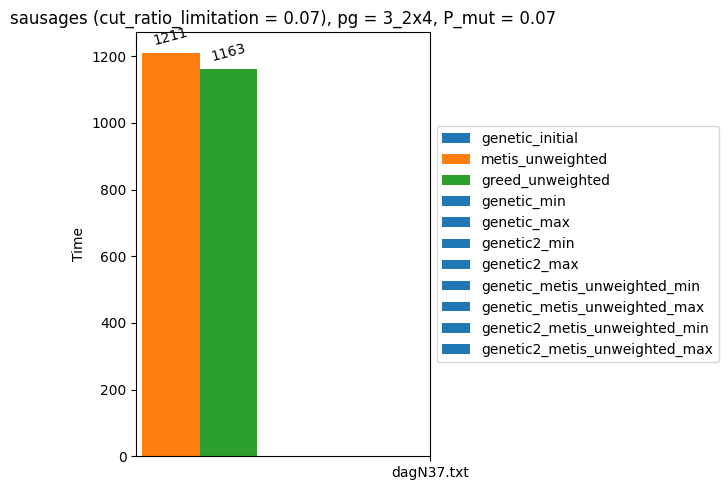

In [33]:
# ПЕРВЫЙ СЛАЙД 2
# x = np.arange(len(names['sausages']))  # the label locations

names = {
    'sausages': [
        # 'dagA15.txt',
        # 'dagA7.txt',
        # 'dagA11.txt',
        # 'dagA14.txt',
        # 'dagA15.txt',
        # 'dagA20.txt',
        # 'dagE8.txt',
        # 'dagF13.txt',
        # 'dagK43.txt',
        # 'dagK46.txt',
        'dagN37.txt',
        # 'dagO36.txt',
        # 'dagR56.txt',
        # 'dagJ57.txt',
        # 'dagJ45.txt',
        # 'dagE35.txt',
        # 'dagC19.txt',
        # 'dagD13.txt',
        # 'dagD20.txt',
        # 'dagD30.txt',
        # 'dagD33.txt',
        # 'dagP65.txt',
        # 'dagR56.txt',
        # 'dagH14.txt',
        # 'dagI30.txt',
        # 'dagG33.txt',
        # 'dagP65.txt',
    ],

    'testing_graphs': [
        # 'gapgap2_big.txt',
        # 'gapgap2_big2.txt',
        # 'gapgap2_even_bigger.txt',
        # 'gapgap2_even_bigger_and_correct.txt',
        # 'gapgap2_big2.txt',
        # 'gapgap2_2_3.txt',
        # 'nice_graph.txt',
        'Larry2.txt',
        # 'Larry3.txt',
        # 'Larry3_inv.txt',
        # 'Larry3_inv.txt',
        # 'trans.txt',
        # 'uber_gan.txt',
        # 'uber_gan_heavy.txt',
        # 'sputnik.txt'
    ],
}

data = read_data()
# BIG_NUMBER = 1200
data_name = 'testing_graphs'
data_name = 'sausages'
# data_name = 'dagK43.txt'
x_labels = []
cut_ratio_limitation = 0.07
P_mut = 0.07
# physical_graph = '1234x1.txt'
physical_graph = '3_2x4.txt'

greed_weighted = []
greed_unweighted = []
metis_weighted = []
metis_unweighted = []
genetic_min = []
genetic_max = []
genetic_metis_weighted_min = []
genetic_metis_weighted_max = []
genetic_metis_unweighted_min = []
genetic_metis_unweighted_max = []

genetic_greed_weighted_min = []
genetic_greed_weighted_max = []
genetic_greed_unweighted_min = []
genetic_greed_unweighted_max = []

genetic2_min = []
genetic2_max = []
genetic2_metis_weighted_min = []
genetic2_metis_weighted_max = []
genetic2_metis_unweighted_min = []
genetic2_metis_unweighted_max = []

genetic2_greed_weighted_min = []
genetic2_greed_weighted_max = []
genetic2_greed_unweighted_min = []
genetic2_greed_unweighted_max = []

genetic_initial = []

for algorithm_name in data[data_name]:
    for graph_name in data[data_name][algorithm_name]:
        x_labels.append(graph_name)
    break

# print(list(data.keys()))

for algorithm_name in data[data_name]:
    # print(algorithm_name)
    if algorithm_name == 'greed_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    greed_unweighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break
    elif algorithm_name == 'genetic_initial':
        for graph_name in data[data_name][algorithm_name]:
            # print('ok')
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    genetic_initial.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break
    elif algorithm_name == 'GAP':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_min.append(
                min(f_vals)
            )
            genetic_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'GAP2':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic2_min.append(
                min(f_vals)
            )
            genetic2_max.append(    
                max(f_vals)
            )
    elif algorithm_name == 'genetic_metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_metis_unweighted_min.append(
                min(f_vals)
            )
            genetic_metis_unweighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic2_metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic2_metis_unweighted_min.append(
                min(f_vals)
            )
            genetic2_metis_unweighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    metis_unweighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break


all_val = genetic2_min + genetic2_max + genetic_min + genetic_max +\
    genetic2_greed_unweighted_min + genetic2_greed_unweighted_max +\
    genetic2_greed_weighted_min + genetic2_greed_weighted_max +\
    genetic_greed_unweighted_min + genetic_greed_unweighted_max +\
    genetic_greed_weighted_min + genetic_greed_weighted_max +\
    genetic2_metis_unweighted_min + genetic2_metis_unweighted_max +\
    genetic2_metis_weighted_min + genetic2_metis_weighted_max +\
    genetic_metis_unweighted_min + genetic_metis_unweighted_max +\
    genetic_metis_weighted_min + genetic_metis_weighted_max +\
    greed_unweighted + greed_weighted +\
    metis_unweighted + metis_weighted

# print(genetic_initial)

all_val = list(filter(lambda x: x < 1e10, all_val))
BIG_NUMBER = int(max(all_val) * 1.4)


genetic_initial = f(genetic_initial)

metis_unweighted = f(metis_unweighted)
greed_unweighted = f(greed_unweighted)

genetic_min = f(genetic_min)
genetic_max = f(genetic_max)

genetic2_min = f(genetic2_min)
genetic2_max = f(genetic2_max)

genetic_metis_unweighted_min = f(genetic_metis_unweighted_min)
genetic_metis_unweighted_max = f(genetic_metis_unweighted_max)

genetic2_metis_unweighted_min = f(genetic2_metis_unweighted_min)
genetic2_metis_unweighted_max = f(genetic2_metis_unweighted_max)

print('---------')

print(genetic_initial)
print(metis_unweighted)
print(greed_unweighted)

print(genetic_min)
print(genetic_max)

print(genetic2_min)
print(genetic2_max)

print(genetic_metis_unweighted_min)
print(genetic_metis_unweighted_max)

print(genetic2_metis_unweighted_min)
print(genetic2_metis_unweighted_max)


title = data_name + f' (cut_ratio_limitation = {cut_ratio_limitation}), pg = {physical_graph.split(".")[0]}, P_mut = {P_mut}'

width = 2  # the width of the bars
x = 10*width*np.arange(len(x_labels))  # the label locations

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(len(x_labels)*5)

rects0 = ax.bar(x - 11*width/2, genetic_initial, width, label='genetic_initial')
rects1 = ax.bar(x - 9*width/2, metis_unweighted, width, label='metis_unweighted')
rects2 = ax.bar(x - 7*width/2, greed_unweighted, width, label='greed_unweighted')
rects3 = ax.bar(x - 5*width/2, genetic_min, width, label='genetic_min')
rects4 = ax.bar(x - 3*width/2, genetic_max, width, label='genetic_max')
rects5 = ax.bar(x - 1*width/2, genetic2_min, width, label='genetic2_min')
rects6 = ax.bar(x + 1*width/2, genetic2_max, width, label='genetic2_max')
rects7 = ax.bar(x + 3*width/2, genetic_metis_unweighted_min, width, label='genetic_metis_unweighted_min')
rects8 = ax.bar(x + 5*width/2, genetic_metis_unweighted_max, width, label='genetic_metis_unweighted_max')
rects9 = ax.bar(x + 7*width/2, genetic2_metis_unweighted_min, width, label='genetic2_metis_unweighted_min')
rects10 = ax.bar(x + 9*width/2, genetic2_metis_unweighted_max, width, label='genetic2_metis_unweighted_max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()

        ax.annotate('{}'.format('∞' if height > BIG_NUMBER else height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation = 15
        )


autolabel(rects0)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)
autolabel(rects7)
autolabel(rects8)
autolabel(rects9)
autolabel(rects10)

fig.tight_layout()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [37]:
def input_networkx_graph_from_file(path: str) -> nx.Graph:
    G = nx.Graph()
    with open(path, 'r') as f:
        for line in f.readlines()[1:]:
            name, size, *children = map(int, line.strip().split())
            name = int(name)
            children = list(map(int, children))
            G.add_node(name, weight=size)
            G.add_edges_from((name, child) for child in children)
    G.graph['node_weight_attr'] = 'weight'
    
    return G

---------
[1242]
[1103]
[1218]
[1242]
[]
[]


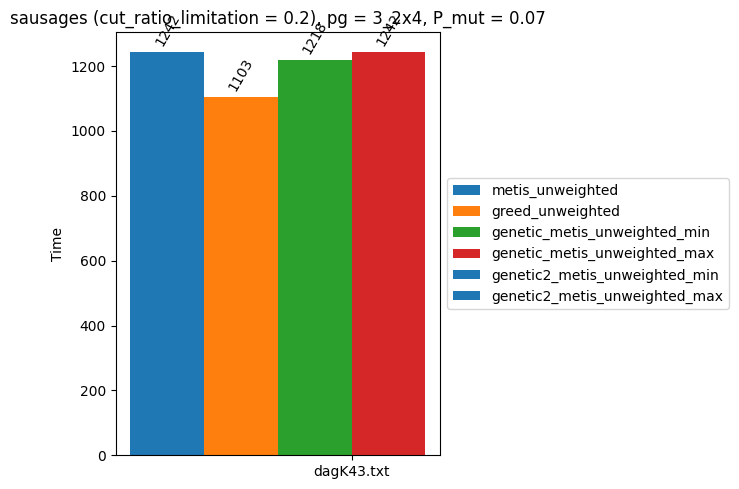

In [29]:
# x = np.arange(len(names['sausages']))  # the label locations
data = read_data()

names = {
    'sausages': [
        # 'dagA15.txt',
        # 'dagA7.txt',
        # 'dagA11.txt',
        # 'dagA14.txt',
        # 'dagA15.txt',
        # 'dagA20.txt',
        # 'dagE8.txt',
        # 'dagF13.txt',
        'dagK43.txt',
        # 'dagK46.txt',
        # 'dagN37.txt',
        # 'dagO36.txt',
        # 'dagR56.txt',
        # 'dagJ57.txt',
        # 'dagJ45.txt',
        # 'dagE35.txt',
        # 'dagC19.txt',
        # 'dagD13.txt',
        # 'dagD20.txt',
        # 'dagD30.txt',
        # 'dagD33.txt',
        # 'dagP65.txt',
        # 'dagR56.txt',
        # 'dagH14.txt',
        # 'dagI30.txt',
        # 'dagG33.txt',
        # 'dagP65.txt',
    ],

    'testing_graphs': [
        # 'gapgap2_big.txt',
        # 'gapgap2_big2.txt',
        # 'gapgap2_even_bigger.txt',
        # 'gapgap2_even_bigger_and_correct.txt',
        # 'gapgap2_big2.txt',
        # 'gapgap2_2_3.txt',
        # 'nice_graph.txt',
        # 'Larry2.txt',
        # 'Larry3.txt',
        'Larry3_inv.txt',
        # 'Larry3_inv.txt',
        # 'trans.txt',
        # 'uber_gan.txt',
        # 'uber_gan_heavy.txt',
        # 'sputnik.txt'
    ],
}

# BIG_NUMBER = 1200
# data_name = 'testing_graphs'
data_name = 'sausages'
# data_name = 'dagK43.txt'
x_labels = []
cut_ratio_limitation = 0.2
P_mut = 0.07
# physical_graph = '1234x1.txt'
physical_graph = '3_2x4.txt'

greed_unweighted = []
metis_unweighted = []
genetic_metis_unweighted_min = []
genetic_metis_unweighted_max = []

genetic2_metis_unweighted_min = []
genetic2_metis_unweighted_max = []

for algorithm_name in data[data_name]:
    for graph_name in data[data_name][algorithm_name]:
        x_labels.append(graph_name)
    break

for algorithm_name in data[data_name]:
    if algorithm_name == 'greed_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    greed_unweighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break
    elif algorithm_name == 'genetic_metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_metis_unweighted_min.append(
                min(f_vals)
            )
            genetic_metis_unweighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic2_metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic2_metis_unweighted_min.append(
                min(f_vals)
            )
            genetic2_metis_unweighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'metis_unweighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    metis_unweighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break


all_val = genetic2_min + genetic2_max + genetic_min + genetic_max +\
    genetic2_greed_unweighted_min + genetic2_greed_unweighted_max +\
    genetic2_greed_weighted_min + genetic2_greed_weighted_max +\
    genetic_greed_unweighted_min + genetic_greed_unweighted_max +\
    genetic_greed_weighted_min + genetic_greed_weighted_max +\
    genetic2_metis_unweighted_min + genetic2_metis_unweighted_max +\
    genetic2_metis_weighted_min + genetic2_metis_weighted_max +\
    genetic_metis_unweighted_min + genetic_metis_unweighted_max +\
    genetic_metis_weighted_min + genetic_metis_weighted_max +\
    greed_unweighted + greed_weighted +\
    metis_unweighted + metis_weighted

# print(all_val)
all_val = list(filter(lambda x: x <1e10, all_val))
BIG_NUMBER = int(max(all_val) * 1.2)

greed_unweighted = f(greed_unweighted)
metis_unweighted = f(metis_unweighted)

genetic_metis_unweighted_min = f(genetic_metis_unweighted_min)
genetic_metis_unweighted_max = f(genetic_metis_unweighted_max)

genetic2_metis_unweighted_min = f(genetic2_metis_unweighted_min)
genetic2_metis_unweighted_max = f(genetic2_metis_unweighted_max)

print('---------')

print(metis_unweighted)

print(greed_unweighted)

print(genetic_metis_unweighted_min)
print(genetic_metis_unweighted_max)

print(genetic2_metis_unweighted_min)
print(genetic2_metis_unweighted_max)

title = data_name + f' (cut_ratio_limitation = {cut_ratio_limitation}), pg = {physical_graph.split(".")[0]}, P_mut = {P_mut}'

width = 2  # the width of the bars
x = 30*width*np.arange(len(x_labels))  # the label locations

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(len(x_labels)*5)

rects1 = ax.bar(x - 5*width/2, metis_unweighted, width, label='metis_unweighted')
rects2 = ax.bar(x - 3*width/2, greed_unweighted, width, label='greed_unweighted')
rects3 = ax.bar(x - 1*width/2, genetic_metis_unweighted_min, width, label='genetic_metis_unweighted_min')
rects4 = ax.bar(x + 1*width/2, genetic_metis_unweighted_max, width, label='genetic_metis_unweighted_max')
rects5 = ax.bar(x + 3*width/2, genetic2_metis_unweighted_min, width, label='genetic2_metis_unweighted_min')
rects6 = ax.bar(x + 5*width/2, genetic2_metis_unweighted_max, width, label='genetic2_metis_unweighted_max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()

        ax.annotate('{}'.format('∞' if height > BIG_NUMBER else height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation = 0 if height > BIG_NUMBER else 60
        )


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

fig.tight_layout()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [22]:

# x = np.arange(len(names['sausages']))  # the label locations

names = {
    'sausages': [
        # 'dagK43.txt',
        # 'dagE8.txt',
        # 'dagK46.txt',
        # 'dagO36.txt',
        # 'dagA15.txt',
        # 'dagF13.txt',
        # 'dagR56.txt',
        # 'dagPN37.txt',
    ],

    'testing_graphs': [
        # 'gapgap2_big.txt',
        'gapgap2_big2.txt',
        # 'gapgap2_even_bigger.txt',
        # 'gapgap2_even_bigger_and_correct.txt',
        # 'gapgap2_2_3.txt',
        # 'nice_graph.txt',
        # 'Larry2.txt',
        # 'Larry3.txt',
        # 'Larry3_inv.txt',
        # 'trans.txt',
        # 'uber_gan.txt',
        # 'uber_gan_heavy.txt',
        # 'sputnik.txt',
        # 'mk_test_tiny_ex.txt'
    ],
}

data = read_data()
BIG_NUMBER = 1200
data_name = 'testing_graphs'
# data_name = 'sausages'
# data_name = 'dagK43.txt'
x_labels = []
cut_ratio_limitation = 0.2
P_mut = 0.07
physical_graph = '1234x1.txt'
# physical_graph = '3_2x1correct.txt'

metis_weighted = []
metis_unweighted = []
metis_from_mk_weighted = []
metis_from_mk_unweighted = []

metis_from_mk_weighted_unweighted = []
metis_from_mk_weighted_weighted = []
metis_from_mk_unweighted_unweighted = []
metis_from_mk_unweighted_weighted = []

greed_weighted = []
greed_from_mk_weighted_weighted = []

genetic_metis_weighted_min = []
genetic_metis_weighted_max = []
genetic_metis_unweighted_min = []
genetic_metis_unweighted_max = []

genetic2_metis_weighted_min = []
genetic2_metis_weighted_max = []
genetic2_metis_unweighted_min = []
genetic2_metis_unweighted_max = []

genetic_metis_weighted_min = []
genetic_metis_weighted_max = []

gap_mk_weighted_min = []
gap_mk_weighted_max = []

gap2_mk_weighted_min = []
gap2_mk_weighted_max = []

for algorithm_name in data[data_name]:
    for graph_name in data[data_name][algorithm_name]:
        x_labels.append(graph_name)
    break

for algorithm_name in data[data_name]:
    if algorithm_name == 'metis_weighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    metis_weighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break
    elif algorithm_name == 'gap_mk_weighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            gap_mk_weighted_min.append(
                min(f_vals)
            )
            gap_mk_weighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'gap2_mk_weighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            gap2_mk_weighted_min.append(
                min(f_vals)
            )
            gap2_mk_weighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'greed_from_mk_weighted_weighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                print('ok?')
                # print(data[data_name][algorithm_name][graph_name][i], '<-')
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    greed_from_mk_weighted_weighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break
    elif algorithm_name == 'genetic_metis_weighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic_metis_weighted_min.append(
                min(f_vals)
            )
            genetic_metis_weighted_max.append(
                max(f_vals)
            )
    elif algorithm_name == 'genetic2_metis_weighted':
        for graph_name in data[data_name][algorithm_name]:
            f_vals = []
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][6] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1] and\
                        P_mut == data[data_name][algorithm_name][graph_name][i][2]:
                    f_vals.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
            assert len(f_vals), (data_name, algorithm_name, graph_name)
            genetic2_metis_weighted_min.append(
                min(f_vals)
            )
            genetic2_metis_weighted_max.append(
                max(f_vals)
            )
    if algorithm_name == 'greed_weighted':
        for graph_name in data[data_name][algorithm_name]:
            for i in range(len(data[data_name][algorithm_name][graph_name])):
                # print
                if cut_ratio_limitation == data[data_name][algorithm_name][graph_name][i][4] and\
                        physical_graph == data[data_name][algorithm_name][graph_name][i][1]:
                    greed_weighted.append(
                        data[data_name][algorithm_name][graph_name][i][-2]
                    )
                    break


# all_val = genetic2_min + genetic2_max + genetic_min + genetic_max +\
#     genetic2_greed_unweighted_min + genetic2_greed_unweighted_max +\
#     genetic2_greed_weighted_min + genetic2_greed_weighted_max +\
#     genetic_greed_unweighted_min + genetic_greed_unweighted_max +\
#     genetic_greed_weighted_min + genetic_greed_weighted_max +\
#     genetic2_metis_unweighted_min + genetic2_metis_unweighted_max +\
#     genetic2_metis_weighted_min + genetic2_metis_weighted_max +\
#     genetic_metis_unweighted_min + genetic_metis_unweighted_max +\
#     genetic_metis_weighted_min + genetic_metis_weighted_max +\
#     greed_unweighted + greed_weighted +\
#     metis_unweighted + metis_weighted

all_val = list(filter(lambda x: x <1e10, all_val))
BIG_NUMBER = int(max(all_val) * 1.2)


metis_weighted = f(metis_weighted)
metis_unweighted = f(metis_unweighted)

genetic_metis_unweighted_min = f(genetic_metis_unweighted_min)
genetic_metis_unweighted_max = f(genetic_metis_unweighted_max)
genetic_metis_weighted_min = f(genetic_metis_weighted_min)
genetic_metis_weighted_max = f(genetic_metis_weighted_max)

print('---------')

# print(metis_weighted)
# print(metis_unweighted)
# print(genetic_metis_unweighted_min)
# print(genetic_metis_unweighted_max)
# print(genetic_metis_weighted_min)
# print(genetic_metis_weighted_max)

title = data_name + f' (cut_ratio_limitation = {cut_ratio_limitation}), pg = {physical_graph.split(".")[0]}, P_mut = {P_mut}'

width = 2  # the width of the bars
x = 10*width*np.arange(len(x_labels))  # the label locations

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(len(x_labels)*5)

print(metis_weighted)
print(greed_weighted)
print(greed_from_mk_weighted_weighted)
print(genetic_metis_weighted_min)
print(genetic_metis_weighted_max)
print(gap_mk_weighted_min)
print(gap_mk_weighted_max)
print(gap2_mk_weighted_min)
print(gap2_mk_weighted_max)

rects1 = ax.bar(x - 5*width/2, metis_weighted, width, label='metis_weighted')
rects2 = ax.bar(x - 3*width/2, greed_weighted, width, label='greed_weighted')
rects3 = ax.bar(x - 1*width/2, greed_from_mk_weighted_weighted, width, label='greed_from_mk_weighted')
rects4 = ax.bar(x + 1*width/2, genetic_metis_weighted_min, width, label='genetic_metis_weighted_min')
rects5 = ax.bar(x + 3*width/2, genetic_metis_weighted_max, width, label='genetic_metis_weighted_max')
rects6 = ax.bar(x + 5*width/2, gap_mk_weighted_min, width, label='gap_mk_weighted_min')
rects7 = ax.bar(x + 7*width/2, gap_mk_weighted_max, width, label='gap_mk_weighted_max')
rects8 = ax.bar(x + 9*width/2, gap2_mk_weighted_min, width, label='gap2_mk_weighted_min')
rects9 = ax.bar(x + 11*width/2, gap2_mk_weighted_max, width, label='gap2_mk_weighted_max')

# rects3 = ax.bar(x - 1*width/2, genetic_metis_unweighted_min, width, label='genetic_metis_unweighted_min')
# rects4 = ax.bar(x + 1*width/2, genetic_metis_unweighted_max, width, label='genetic_metis_unweighted_max')
# rects5 = ax.bar(x + 3*width/2, genetic_metis_weighted_min, width, label='genetic_metis_weighted_min')
# rects6 = ax.bar(x + 5*width/2, genetic_metis_weighted_max, width, label='genetic_metis_weighted_max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_title(title)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()

        ax.annotate('{}'.format('∞' if height > BIG_NUMBER else height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation = 0 if height > BIG_NUMBER else 60
        )


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

AssertionError: ('testing_graphs', 'genetic_metis_weighted', 'gapgap2_big2.txt')

In [13]:
!ls

FastMap  GAP3	    __init__.py  data_mk    research.ipynb
GAP	 MK	    __pycache__  delete.py  results
GAP2	 README.md  data	 greed	    results1


In [180]:
path_greed = './results2/greed/weighted/{}'
# path_greed = './results/greed/weighted/{}'
path_greed_mk = path_greed.replace('greed', 'MK_greed_greed_weighted')
# path_greed_mk = path_greed.replace('greed', 'MK_greed_greed_with_geq_cr')
path_greed = './results/greed/weighted/{}'
path_simple: str = './results2/simple_part/weighted/{}'

# graph_name = 'triangle/triadag25_7.txt'
# graph_name = 'testing_graphs/16_envelope_mk_eq.txt'
# graph_name = 'sausages/dagD39.txt' # 65 вершин
# graph_name = 'sausages/dagR62.txt' # 200 вершин
# graph_name = 'sausages/dagM5.txt'
# graph_name = 'sausages/dagP38.txt'
# graph_name = 'sausages/dagK43.txt'
# graph_name = 'sausages/dagE8.txt'
# graph_name = 'rand/dag26.txt'
# graph_name = 'triangle/triadag10_5.txt'

# ./results2/MK_greed_greed_with_geq_cr/weighted/testing_graphs/16_envelope_mk_eq.txt 64
# ./results2/MK_greed_greed_with_geq_cr/weighted/testing_graphs/16_envelope_mk_rand.txt 64
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagA15.txt 50
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagH28.txt 85
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagK43.txt 130
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagN19.txt 160
# ./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagR49.txt 200
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag26.txt 31
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag15.txt 48
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag16.txt 67
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag13.txt 83
# ./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag0.txt 96
# ./results2/MK_greed_greed_with_geq_cr/weighted/triangle/triadag10_5.txt 55
# ./results2/MK_greed_greed_with_geq_cr/weighted/triangle/triadag15_4.txt 120
# ./results2/MK_greed_greed_with_geq_cr/weighted/triangle/triadag20_5.txt 210
# ./results2/MK_greed_greed_with_geq_cr/weighted/triangle/triadag25_0.txt 325

graph_name = 'triangle/triadag25_0.txt.txt'


path_greed = path_greed.format(graph_name)
path_greed_mk = path_greed_mk.format(graph_name)
path_simple = path_simple.format(graph_name)

In [181]:
greed_data = defaultdict(dict)
greed_mk_data = defaultdict(dict)
simple_data = defaultdict(dict)

cr_set = set()

with open(path_simple, 'r') as file:
    for line in file.readlines():
        line = line.strip()
        _, pg_name, _, cr, cr_lim, f_val, *_ = line.split()

        pg_name = pg_name.rstrip('.txt')
        pg_name = '_'.join(list(map(str, sorted(list(map(int, pg_name.split('x')[0].split('_'))), reverse=True)))) + 'x' + pg_name.split('x')[1]
        
        # cr_set.add(cr_lim)
        simple_data[pg_name][cr_lim] = float(f_val)

with open(path_greed, 'r') as file:
    for line in file.readlines():
        line = line.strip()
        _, pg_name, _, cr, cr_lim, f_val, *_ = line.split()

        pg_name = pg_name.rstrip('.txt')
        pg_name = '_'.join(list(map(str, sorted(list(map(int, pg_name.split('x')[0].split('_'))), reverse=True)))) + 'x' + pg_name.split('x')[1]
        
        # cr_set.add(cr_lim)
        greed_data[pg_name][cr_lim] = float(f_val)

with open(path_greed_mk, 'r') as file:
    for line in file.readlines():
        line = line.strip()
        _, pg_name, _, cr, cr_lim, f_val, *_ = line.split()

        pg_name = pg_name.rstrip('.txt')
        pg_name = '_'.join(list(map(str, sorted(list(map(int, pg_name.split('x')[0].split('_'))), reverse=True)))) + 'x' + pg_name.split('x')[1]
        
        cr_set.add(cr_lim)
        greed_mk_data[pg_name][cr_lim] = float(f_val)
print()

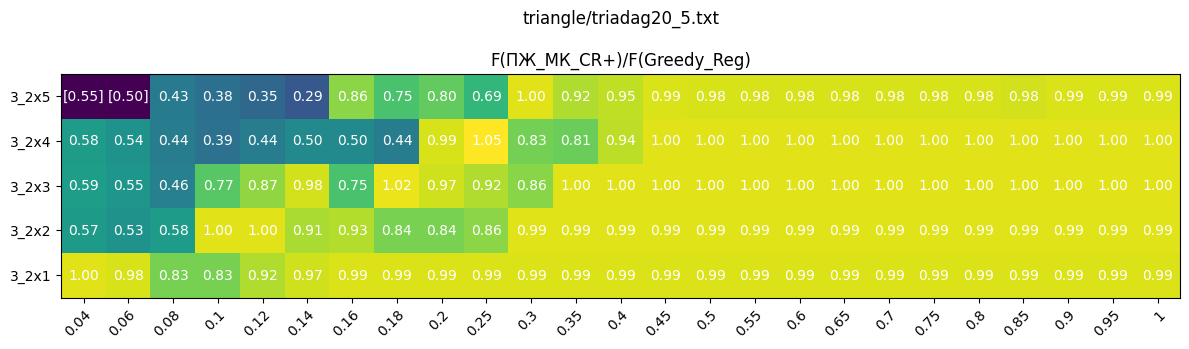

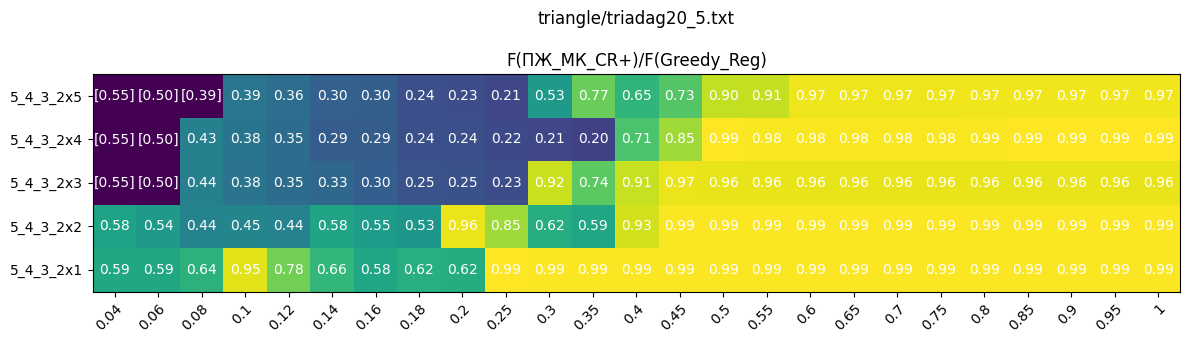

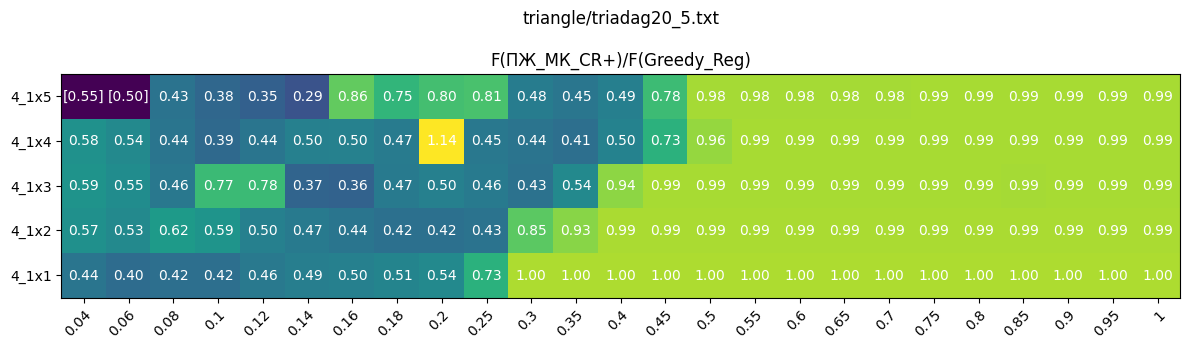

In [182]:
cr_list = sorted(list(cr_set))

# cr_list = ['0.4']


pg_names0 = list(greed_mk_data.keys())

pgs = list(set(pg.split('x')[0] for pg in pg_names0))

# minimum_heat = 1e11
# maximum_heat = 0

# for pg in pgs:
#     pg_names = filter(lambda x: x.startswith(pg) , pg_names0)
#     pg_names = list(sorted(
#         pg_names,
#         key=lambda x: int(x.split('x')[1]),
#         reverse=True,
#     ))

#     for i, pg_name in enumerate(pg_names):
#         for cr in cr_list:
#             heat_val = greed_mk_data[pg_name][cr] / greed_data[pg_name][cr]
#             minimum_heat = min(minimum_heat, heat_val)
#             maximum_heat = max(maximum_heat, heat_val)

    

for pg in pgs:
    pg_names = filter(lambda x: x.startswith(pg) , pg_names0)
    pg_names = list(sorted(
        pg_names,
        key=lambda x: int(x.split('x')[1]),
        reverse=True,
    ))

    heats = [[] for _ in pg_names]
    simple = [[] for _ in pg_names]
    
    for i, pg_name in enumerate(pg_names):
        for cr in cr_list:
            heats[i].append(
                greed_mk_data[pg_name][cr] / greed_data[pg_name][cr]
            )

            simple[i].append(
                greed_mk_data[pg_name][cr] / simple_data[pg_name][cr]
            )
    
    heats = np.array(heats)
    simple = np.array(simple)
    
    fig, ax = plt.subplots(figsize=(len(cr_list)//2, len(pg_name)))
    # im = ax.imshow(heats, vmin=minimum_heat, vmax=maximum_heat)
    im = ax.imshow(heats)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cr_list)), labels=cr_list)
    ax.set_yticks(np.arange(len(pg_names)), labels=pg_names)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(pg_names)):
        for j in range(len(cr_list)):
            val = f'{heats[i, j]:.2f}' if heats[i, j] > 0.001 else f'[{simple[i, j]:.2f}]'
            text = ax.text(j, i, f'{val}',
                           ha="center", va="center", color="w")
    
    # ax.set_title(f'F(Greedy_MC{"_CR+" if "1" in path_greed_mk else ""})/F(Greedy_Reg)\n\n' + graph_name.split('/')[-1])
    title = f'{graph_name}\n\n' + f'F(ПЖ_МК{"_CR+" if "geq_cr" in path_greed_mk else ""})/F(Greedy_Reg)'
    title = title.replace("sausages", "layered")
    ax.set_title(title)

    fig.tight_layout()
    plt.show()

In [ ]:
!tail ./results1/metis_from_mk_weighted/weighted/testing_graphs/16_envelope_mk_eq.txt

16_envelope_mk_eq.txt 3_2x1.txt True 0.18248175182481752 0.55 13.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
16_envelope_mk_eq.txt 3_2x1.txt True 0.18248175182481752 0.6 13.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
16_envelope_mk_eq.txt 3_2x1.txt True 0.18248175182481752 0.65 13.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
16_envelope_mk_eq.txt 3_2x1.txt True 0.18248175182481752 0.7 13.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1

In [102]:
# !cat ./data_mk/16_envelope_mk_eq_weighted1.mapping
# !cat ./data_mk/16_envelope_mk_eq_weighted1.txt

49 47 44 43 37 36 30 32 48 49 45 46 38 39 32 31 50 52 41 42 34 33 28 27 52 51 42 40 35 35 29 29 7 8 0 2 20 22 15 14 9 9 2 1 21 22 16 16 10 13 4 3 23 24 19 18 12 11 5 6 25 26 19 17name weight children
0 1 42 8 2 1 
1 1 2 21 3 
2 2 40 20 4 
3 1 4 23 6 5 
4 1 13 5 6 
5 1 6 
6 1 25 
7 1 52 8 9 
8 1 9 
9 2 10 
10 1 13 12 11 
11 1 13 12 
12 1 13 
13 1 
14 1 29 15 16 
15 1 29 22 16 
16 2 22 19 18 
17 1 19 18 
18 1 19 
19 2 24 26 
20 1 35 22 21 
21 1 22 23 
22 2 35 24 
23 1 24 25 26 
24 1 26 25 
25 1 26 
26 1 
27 1 31 28 29 
28 1 32 33 29 
29 2 35 
30 1 36 32 31 
31 1 32 
32 2 39 
33 1 39 34 35 
34 1 38 42 35 
35 2 40 
36 1 37 39 38 
37 1 43 38 39 
38 1 46 39 
39 1 
40 1 41 42 
41 1 45 52 42 
42 2 46 
43 1 44 46 45 
44 1 47 45 46 
45 1 46 
46 1 
47 1 49 48 
48 1 49 50 
49 2 
50 1 52 51 
51 1 52 
52 2 


In [9]:
print(np.linspace(55, 500, 5))

[ 55.   166.25 277.5  388.75 500.  ]


In [1]:
graph_path = './data/testing_graphs/64_envelope_mk_rand.txt'
graph = input_networkx_graph_from_file(graph_path)
n2 = len(graph.nodes)
n = int(n2**0.5)
pos = [((i % n), -(i // n)) for i in range(n2)]

# partition = np.array([6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # partition /= np.max(partition)

nx.draw(graph, pos, with_labels=False, node_size=[100]*n2, )
# nx.draw(graph, pos, node_color=partition, with_labels=False, node_size=[100]*n2, )

NameError: name 'input_networkx_graph_from_file' is not defined

In [ ]:
# * МЕТИС-взвеш
# * МЕТИС-невзвеш
#   * ВНИМАНИЕ! Нач.разбиение от МЕТИСа (взвеш, невзвеш) раскладываем по процессорам так, что самая тяжелая группа идет на самый быстрый процессор, и т.п. по убыванию веса групп и произв-ти процессоров.
# * ЖА-обычн от МЕТИС-взвеш
# * ЖА-обычн от МЕТИС-невзвеш
# * Генетика старая от МЕТИС-взвеш (мин, макс)
# * Генетика старая от МЕТИС-невзвеш (мин, макс)
# * Генетика новая от МЕТИС-взвеш (мин, макс)
# * Генетика новая от МЕТИС-невзвеш (мин, макс)
# * ПЖ_МК
# * ПЖ_МК_CR+

./results/GAP_metis/weighted/sausages/dagA15.txt
./results/GAP_metis/unweighted/sausages/dagA15.txt
./results/GAP2_metis/weighted/sausages/dagA15.txt
./results/GAP2_metis/unweighted/sausages/dagA15.txt


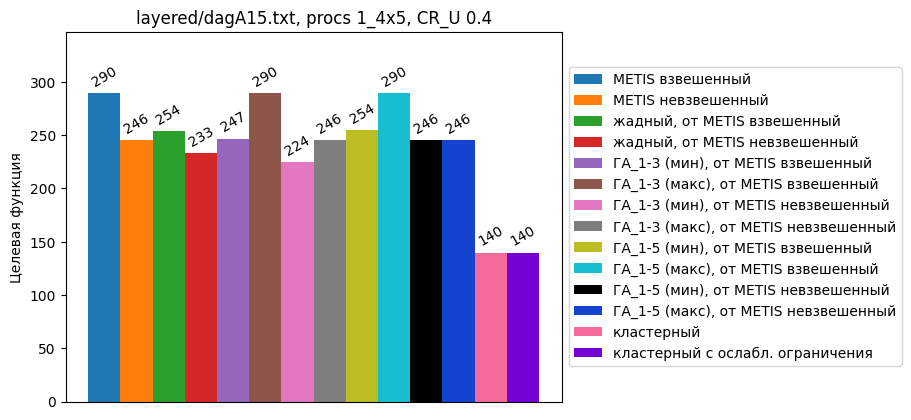

[289.5  245.5  254.   233.25 246.75 289.5  224.5  245.5  254.5  289.5
 245.5  245.5  139.75 139.75]


In [44]:
graph_name = 'triangle/triadag10_5.txt'
graph_name = 'sausages/dagA15.txt'
# graph_name = 'testing_graphs/16_envelope_mk_rand.txt'
# graph_name = 'testing_graphs/16_envelope_mk_eq.txt'
# graph_name = 'rand/dag26.txt'

# pg_name = '3_2x1.txt'
pg_name = '3_2x2.txt'
pg_name = '3_2x3.txt'
pg_name = '3_2x4.txt'
# pg_name = '3_2x5.txt'
# pg_name = '1_4x1.txt'
# pg_name = '1_4x2.txt'
# pg_name = '1_4x3.txt'
# pg_name = '1_4x4.txt'
pg_name = '1_4x5.txt'
# pg_name = '5_4_3_2x1.txt'
# pg_name = '5_4_3_2x2.txt'
# pg_name = '5_4_3_2x3.txt'
# pg_name = '5_4_3_2x4.txt'
# pg_name = '5_4_3_2x5.txt'


cr_u = 0.35
# cr_u = 0.2
cr_u = 0.4
# cr_u = 0.45
iter_u = 100
# iter_u = 50
# cr_u = 0.3
# cr_u = 0.45
# cr_u = 0.4
# cr_u = 0.2

# cr_u_list = [0.2, 0.3, 0.4]

bars = []

names = [
    'METIS взвешенный',
    'METIS невзвешенный',
    'жадный, от METIS взвешенный',
    'жадный, от METIS невзвешенный',
    'ГА_1-3 (мин), от METIS взвешенный',
    'ГА_1-3 (макс), от METIS взвешенный',
    'ГА_1-3 (мин), от METIS невзвешенный',
    'ГА_1-3 (макс), от METIS невзвешенный',
    'ГА_1-5 (мин), от METIS взвешенный',
    'ГА_1-5 (макс), от METIS взвешенный',
    'ГА_1-5 (мин), от METIS невзвешенный',
    'ГА_1-5 (макс), от METIS невзвешенный',
    'кластерный',
    'кластерный с ослабл. ограничения',
]

# for cr_u in cr_u_list:
paths = [
    './results2/metis_with_pg/weighted/{}',
    './results2/metis_with_pg/unweighted/{}',
    './results/greed/weighted/{}',
    './results/greed/unweighted/{}',
]
for path in paths:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        for line in file.readlines():
            _, pg, _, cr, cr_lim, f_val, _ = line.split(maxsplit=6)
            # cr = float(cr)
            cr_lim = float(cr_lim)
            f_val = float(f_val)

            if pg_name == pg and cr_u == cr_lim:
                bars.append(f_val)
                break

paths_genetics = [
    './results/GAP_metis/weighted/{}',
    './results/GAP_metis/unweighted/{}',
    './results/GAP2_metis/weighted/{}',
    './results/GAP2_metis/unweighted/{}',
]
for path in paths_genetics:
    g_min = 1e12
    g_max = 0
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            _, pg, r2, max_iter, cr, _, cr_lim, f_val, _ = line.split(maxsplit=8)
            # cr = float(cr)
            max_iter = int(max_iter)
            cr_lim = float(cr_lim)
            f_val = float(f_val)

            if pg_name == pg and cr_u == cr_lim and iter_u == max_iter:
                # print(f_val)
                g_min = min(g_min, f_val)
                g_max = max(g_max, f_val)

        bars.append(g_min)
        bars.append(g_max)

paths = [
    './results2/MK_greed_greed_weighted/weighted/{}',
    './results2/MK_greed_greed_with_geq_cr/weighted/{}',
]
for path in paths:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        for line in file.readlines():
            _, pg, _, cr, cr_lim, f_val, _ = line.split(maxsplit=6)
            # cr = float(cr)
            cr_lim = float(cr_lim)
            f_val = float(f_val)

            if pg_name == pg and cr_u == cr_lim:
                bars.append(f_val)
                break

x = np.arange(len(bars))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

bars = np.array(bars)
if 'rand' in graph_name:
    bars = (bars / 16384) * 10

fig, ax = plt.subplots()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#1443cf', '#f46a9b', '#7503d5']

for attribute, measurement, color in zip(names, bars, colors):
    offset = width * multiplier
    rects = ax.bar(offset, measurement, width, label=attribute, color=color)
    ax.bar_label(rects, padding=3, rotation=30, fmt='%.0f')
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Целевая функция')
# ax.set_title(f'{graph_name.strip(".txt").split("/")[-1]}')
# ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.strip(".txt")}, CR_U {cr_u}')
# ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.strip(".txt")}, CR_U {cr_u}, ITER_MAX {iter_u}')
ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.strip(".txt")}, CR_U {cr_u}')
# ax.set_xticks(x + width, species)
ax.set_xticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, int(max(filter(lambda x: x < 1e7, bars))*1.2))
plt.show()

print(bars)